In [1]:
%env TF_ENABLE_ONEDNN_OPTS=0

env: TF_ENABLE_ONEDNN_OPTS=0


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

2022-07-22 09:14:33.397498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 09:14:33.397516: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.9.1
We are using Keras 2.9.0


In [5]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

2022-07-22 09:15:10.543143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 09:15:10.544528: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-22 09:15:10.544541: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-22 09:15:10.544559: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ls01): /proc/driver/nvidia/version does not exist


''

In [6]:
#GPU count and name
!nvidia-smi -L

/bin/bash: nvidia-smi: command not found


In [7]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

/bin/bash: nvidia-smi: command not found


# MNIST

In [8]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

In [9]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


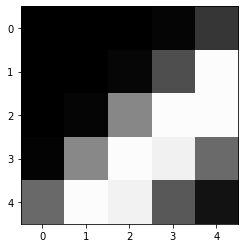

Пример картинки:


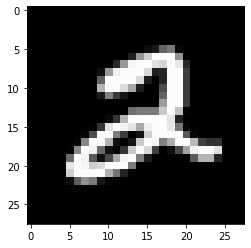

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [10]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

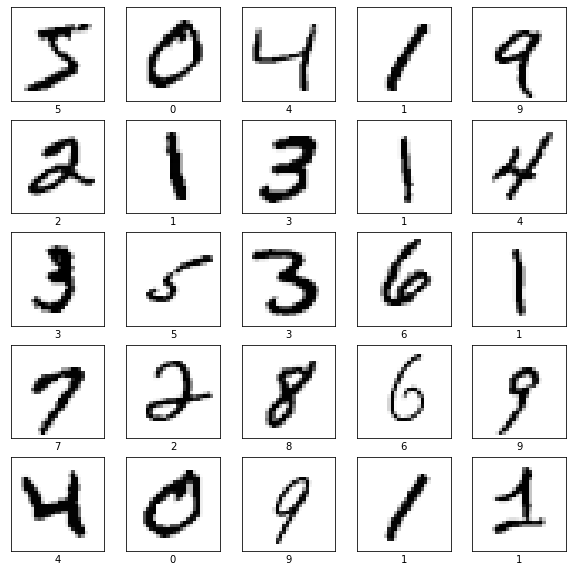

In [11]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [12]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [13]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(float) / 255 - 0.5
x_val_float = x_val_flat.astype(float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(float)
# x_val_float = x_val_flat.astype(float)

In [14]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


# Собираем модель

Построим простой Multi layer Perceptron (MLP) классификатор в Keras (по аналогии со знакомым нам уже MLPClassifier из sklearn)

<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="500">


Сначала надо будет посчитать логиты (logit, линейное преобразование) $z_k$ для каждого класса: $$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

А затем превратить логиты $z_k$ в вероятности $p_k$ при помощи функции softmax: $$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Мы будем использовать cross-entropy для минимизации ошибки: $$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$

где $$ [x]=\begin{cases} 1, \quad \text{если $x$ истина} \\ 0, \quad \text{иначе} \end{cases} $$

Минимизация cross-entropy двигает $p_k$ в сторону 1 когда $y = k$, что как раз мы и хотим.


In [15]:
clear_session()

In [16]:
x_train_float.shape[1]

784

In [17]:
# Архитектура сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [20]:
%%time
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3139 - accuracy: 0.9043 - val_loss: 0.1542 - val_accuracy: 0.9541
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 0.1455 - accuracy: 0.9553 - val_loss: 0.1198 - val_accuracy: 0.9607
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.1077 - accuracy: 0.9660 - val_loss: 0.1016 - val_accuracy: 0.9680
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0877 - accuracy: 0.9717 - val_loss: 0.0923 - val_accuracy: 0.9719
Epoch 5/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0733 - accuracy: 0.9761 - val_loss: 0.0992 - val_accuracy: 0.9697
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0620 - accuracy: 0.9799 - val_loss: 0.0958 - val_accuracy: 0.9722
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0563 - accuracy: 0.9818 - val_loss: 0.0884 - val_accuracy: 0.9724
Epoch 

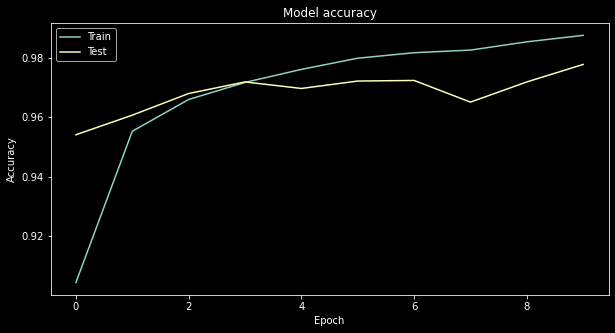

In [21]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

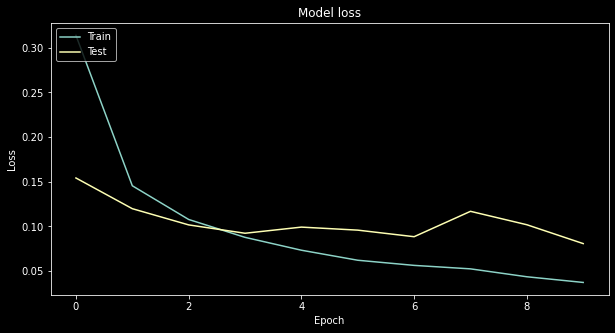

In [22]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
model.predict(x_val_float)

313/313 [==============================] - 0s 435us/step


array([[1.53312367e-08, 1.65507186e-06, 7.66148150e-06, ...,
        9.99687552e-01, 1.14934551e-06, 2.81523917e-05],
       [1.79037583e-11, 4.66810860e-07, 9.99999464e-01, ...,
        9.55059708e-13, 1.77992129e-13, 3.60857005e-18],
       [2.13671947e-09, 9.99747157e-01, 2.37847053e-04, ...,
        1.43816123e-05, 3.83000469e-07, 8.21636092e-08],
       ...,
       [3.65241997e-17, 7.03513690e-13, 1.74275798e-16, ...,
        3.42524906e-08, 3.10266191e-09, 2.23495533e-09],
       [4.28652868e-07, 1.46137924e-09, 5.19208943e-09, ...,
        4.14607086e-08, 3.94695364e-02, 1.41255506e-11],
       [2.33631781e-10, 1.21076760e-13, 1.61461280e-08, ...,
        2.30811099e-15, 6.23721630e-11, 2.61663412e-12]], dtype=float32)

In [24]:
np.argmax(model.predict(x_val_float), axis = 1)

313/313 [==============================] - 0s 432us/step


array([7, 2, 1, ..., 4, 5, 6])

In [25]:
predicts = np.argmax(model.predict(x_val_float), axis = 1)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

313/313 [==============================] - 0s 430us/step
Test Accuracy:  0.9778
